## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from impedance.models.circuits import CustomCircuit
# from impedance.visualization import plot_nyquist # Kept if you want to switch plotting methods

## Data Loading

In [135]:
# --- Data Loading ---
FILENAME = "EIS_10mV_Timing task2025_04_29_11_50_C001.z60"

try:
    data_df = pd.read_csv(
        FILENAME,
        skiprows=11,
        sep='\s+',
        names=["Freq", "Ampl", "Bias", "Time", "Z'", "Z''", "GD", "Err", "Range"],
        header=None
    )
    # Extract frequencies and impedance components
    frequencies = data_df["Freq"].to_numpy()
    # Z' is the real part, Z'' is the imaginary part
    Z_real = data_df["Z'"].to_numpy()
    Z_imag = data_df["Z''"].to_numpy()
    Z = Z_real + 1j * Z_imag


except FileNotFoundError:
    print(f"Error: The file '{FILENAME}' was not found.")
    exit()
except Exception as e:
    print(f"Error reading the CSV file: {e}")
    exit()

data_df

Freq  Ampl      Bias        Time           Z'          Z''   GD  \
0    100000.000000  10.0 -0.246816     3.49460     15.55570      5.27726  0.0   
1     89051.300000  10.0 -0.246816     5.78299     13.80450     16.94240  0.0   
2     79301.400000  10.0 -0.246816     8.05283     13.90250     14.04590  0.0   
3     70618.900000  10.0 -0.246816    13.68890      4.37749      1.17738  0.0   
4     62887.000000  10.0 -0.246816    15.97240      4.40899      1.03117  0.0   
..             ...   ...       ...         ...          ...          ...  ...   
135       0.014616  10.0 -0.246816  1041.78000  33173.20000  -7535.82000  0.0   
136       0.013016  10.0 -0.246816  1120.51000  59320.90000  -4182.78000  0.0   
137       0.011591  10.0 -0.246816  1208.77000  47652.70000  -9034.40000  0.0   
138       0.010322  10.0 -0.246816  1307.67000  38840.50000 -11131.10000  0.0   
139       0.010000  10.0 -0.246816  1409.71000  38631.00000   2761.22000  0.0   

     Err  Range  
0      0      0  
1      0      0  
2      0      0  
3      0      0  
4      0      0  
..   ...    ...  
135    0      0  
136    0      0  
137    0      0  
138    0      0  
139    0      0  

[140 rows x 9 columns]

## Preprocessing

In [164]:
# --- Preprocessing ---
# Keep only the impedance data in the "first quadrant" of a Nyquist plot
# (Re(Z) > 0 and -Im(Z) > 0  => Im(Z) < 0)
mask = (Z.real > 0) & (Z.imag < 0) & (frequencies > 100)
frequencies_filtered = frequencies[mask]
Z_filtered = Z[mask]

if len(Z_filtered) == 0:
    print("Warning: After filtering for the first quadrant, no data points remain.")
    # Decide how to proceed: exit, or try to fit with unfiltered data, etc.
    # For now, we'll try to fit with unfiltered if filtered is empty.
    if len(Z) > 0:
        print("Attempting to fit with unfiltered data.")
        frequencies_to_fit = frequencies
        Z_to_fit = Z
    else:
        print("Error: No data to fit.")
        exit()
else:
    freq_data = frequencies_filtered
    Z_exp = Z_filtered

# Circuit Elements


| Circuit Element | Impedence                                    |
| --------------- | -------------------------------------------- | 
| Resistor        | $$ Z = R $$                                  |
| Capacitor       | $$ Z = \frac{1}{C \cdot j 2 \pi f} $$        |
| Inductor        | $$Z = L \cdot j 2 \pi f $$                   |
| CPE             | $$Z = \frac{1}{Q \cdot (j 2 \pi f)^\alpha}$$ |

| Impedences in parallel | Impedences in series |
| --------------- | -------------------------------------------- | 
| $$ Z_{parallel} = \frac{1}{\frac{1}{Z_1} + \frac{1}{Z_2} + ... + \frac{1}{Z_n}}$$ | $$ Z_{series} = Z_1 + Z_2 + ... + Z_n $$

In [165]:
import functools
import numpy as np

def R(f, R): return np.zeros(len(f)) + (R + 0 * 1j)
def C(f, C): return 1.0 / (C * 1j * (2 * np.pi * np.array(f)) )
def L(f, L): return L * 1j * (2 * np.pi * np.array(f))
def CPE(f, Q, alpha): return 1.0 / (Q * (1j * (2 * np.pi * np.array(f))) ** alpha)

def s(*args): return functools.reduce(np.add, [*args])
def p(*args): return np.reciprocal(functools.reduce(np.add, np.reciprocal([*args])))

f = np.linspace(1e5,1e-2,70)

# Some common-sense tests to make sure the code is correct
assert (s(R(f, 10),R(f, 10)) == R(f, 20)).all()
assert (p(R(f, 10),R(f, 10)) == R(f, 5)).all()
assert (s(C(f, 10),C(f, 10)) == C(f, 5)).all()
assert (p(C(f, 10),C(f, 10)) == C(f, 20)).all()


# Simplified Randles Cell

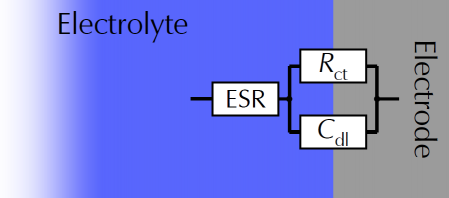

In [166]:
def randles_circuit(f, Rs, Rp, Q, alpha): 
    return s(R(f, Rs), p(R(f, Rp), CPE(f, Q, alpha)))

In [167]:
# Fake data

# Parameters for the simplified Randles circuit (R_s + (R_ct || C_dl))
#freq_data = np.logspace(5, -1, 60) # 10 kHz down to 0.01 Hz
R_s_true = 20.0      # Ohms
R_ct_true = 100.0    # Ohms
Q_dl_true = 1e-5     # Farads
alpha_dl_true = 0.98 # -
Z_fake = randles_circuit(freq_data, R_s_true, R_ct_true, Q_dl_true, alpha_dl_true) + \
        (0.5 + 0.5 * 1j) * np.random.normal(size=freq_data.size)
Z_fake_concat = np.concatenate([Z_exp.real,Z_exp.imag])


## Curve Fitting

Fitting is performed by non-linear least squares regression of circuit model to impedence data via the scipy.optimize.curve_fit function.

The objective function is:
$$ \chi^2 = \sum_{n=0}^{N} [Z^\prime_{exp}(\omega_n) - Z^\prime_{fit}(\omega_n)]^2 +
               [Z^{\prime\prime}_{exp}(\omega_n) - Z^{\prime\prime}_{fit}(\omega_n)]^2 $$
               

In [168]:
def model_func(f, Rs, Rp, Q, alpha):
    Z_fit = randles_circuit(f, Rs, Rp, Q, alpha)
    return np.concatenate([Z_fit.real,Z_fit.imag])

# Initial guesses for the parameters (R_s, R_ct, C_dl)
# Good initial guesses are VERY important for convergence and finding the global minimum.
initial_params_simple = [10.0, 50.0, 1e-6]

# Parameter bounds (optional, but highly recommended)
# Helps to keep parameters within physically realistic ranges.
# Format: ([lower_bounds], [upper_bounds])
bounds_simple = ([0, 0, 1e-9], [1000, 1e4, 1e-2]) # (R_s, R_ct, C_dl)

In [169]:
print("Starting curve_fit for real data...")
try:
    popt, pcov = curve_fit( 
        model_func,
        freq_data,
        np.concatenate([Z_exp.real,Z_exp.imag]),
        # Initial guesses for the parameters (R_s, R_ct, C_dl)        
        p0=[10.0, 50.0, 1e-6, 0.87], 
        # Helps to keep parameters within physically realistic ranges.        
        bounds=([0, 0, 1e-9, 0], [1000, 1e4, 1e-2, 1]), 
        maxfev=50000) # Max number of function evaluations

except RuntimeError:
    print("Curve fitting failed. Could not find optimal parameters.")
    print("Try adjusting initial guesses, bounds, or the model itself.")
except ValueError as e:
    print(f"An error occurred: {e}") 
else:
    print("curve_fit finished successfully!")

Starting curve_fit for real data...
curve_fit finished successfully!


In [170]:
# Results

print("\nOptimized Parameters:")
for name, val in zip(["Rs", "Rp", "Q", "alpha"], popt):
    print(f"{name}: {val:.4e}")

# Standard deviation errors on the parameters
perr = np.sqrt(np.diag(pcov))
print("\nStandard Deviation Errors:")
for name, err in zip(param_names, perr):
    print(f"{name}_err: {err:.2e}")

# Calculate the fitted impedance values using the optimized parameters

Z_fit = randles_circuit(freq_data, *popt)


Optimized Parameters:
Rs: 4.6838e+00
Rp: 1.0000e+04
Q: 3.6437e-05
alpha: 9.6664e-01

Standard Deviation Errors:
R_s_err: 6.84e-02
R_ct_err: 2.04e+04
C_dl_err: 1.34e-06


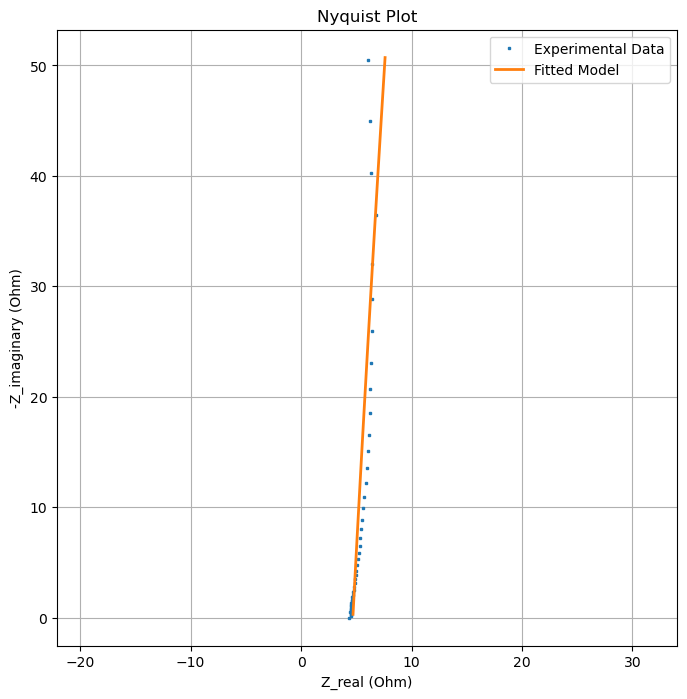

In [171]:
# Nyquist Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(Z_exp.real, -Z_exp.imag, 's', markersize=2, label='Experimental Data')
ax.plot(Z_fit.real, -Z_fit.imag, '-', linewidth=2, label='Fitted Model')
ax.set_xlabel('Z_real (Ohm)')
ax.set_ylabel('-Z_imaginary (Ohm)')
ax.set_title('Nyquist Plot')
ax.legend()
ax.axis('equal') # Important for Nyquist plots
#ax.set_xlim(left=0,   right=popt[0]+popt[1])
#ax.set_ylim(bottom=0, top=popt[0]+popt[1])
ax.grid(True)
plt.show()

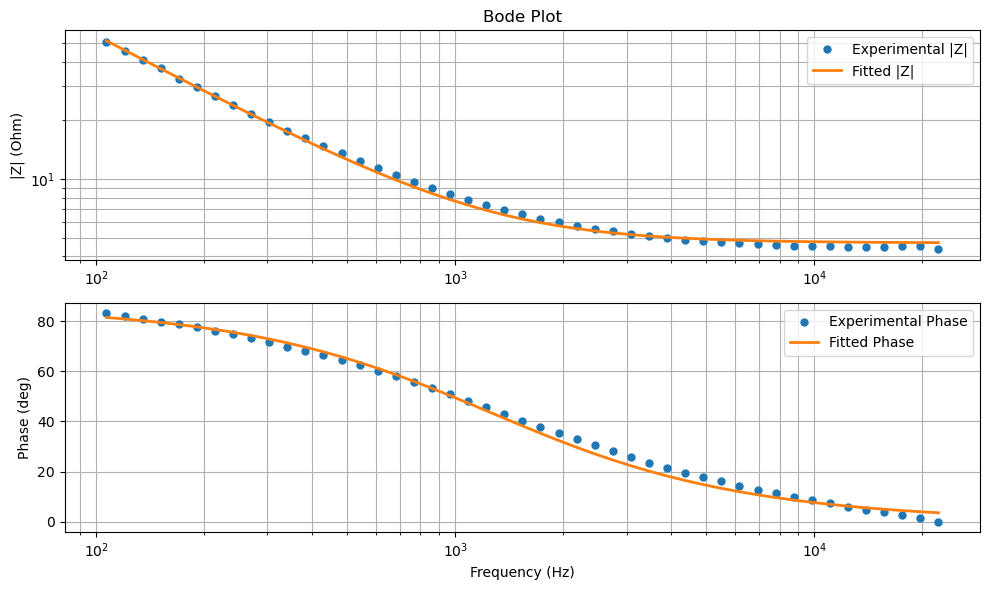

In [172]:
# Bode Plots
plt.figure(figsize=(10, 6))
    
# Magnitude
ax1 = plt.subplot(2, 1, 1)
plt.loglog(freq_data, np.sqrt(Z_exp.real**2 + Z_exp.imag**2), 
           'o', markersize=5, label='Experimental |Z|')
plt.loglog(freq_data, np.sqrt(Z_fit.real**2 + Z_fit.imag**2), 
           '-', linewidth=2, label='Fitted |Z|')
plt.ylabel('|Z| (Ohm)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.title('Bode Plot')

# Phase
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
phase_exp = np.arctan2(-Z_exp.imag, Z_exp.real) * 180 / np.pi
phase_fit = np.arctan2(-Z_fit.imag, Z_fit.real) * 180 / np.pi
plt.semilogx(freq_data, phase_exp, 
             'o', markersize=5, label='Experimental Phase')
plt.semilogx(freq_data, phase_fit, 
             '-', linewidth=2, label='Fitted Phase')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (deg)')
plt.legend()
plt.grid(True, which="both", ls="-")
    
plt.tight_layout()
plt.show()


--- Optimization and Best Practices ---
1.  Model Selection: Choose an equivalent circuit that accurately represents your electrochemical system.
    Start simple and add complexity (e.g., CPE instead of C, Warburg, inductors) if justified by the data and system knowledge.
2.  Initial Guesses (p0): Crucial for convergence and finding the correct solution.
    - Estimate from Nyquist plot features (e.g., R_s from high-freq intercept, R_ct from semicircle diameter).
    - Use values from literature for similar systems.
    - Perform a rough manual fit or a grid search for initial estimates.
3.  Parameter Bounds: Constrain parameters to physically meaningful ranges.
    This prevents the optimizer from exploring unrealistic solutions and can speed up convergence.
4.  Data Quality & Weighting:
    - Ensure your EIS data is clean and free of significant artifacts.
    - If some data points are more reliable than others, use the 'sigma' argument in curve_fit to provide weights (inverse of variance).
    - Logarithmic spacing of frequencies is common and often appropriate.
5.  Function to Fit (model_func):
    - Ensure it correctly calculates the complex impedance for the chosen model.
    - The output format (concatenated real and imaginary parts) is required by curve_fit when fitting complex numbers this way.
6.  Solver Options (curve_fit arguments):
    - `maxfev`: Increase if the fit terminates prematurely (max function evaluations reached).
    - `ftol`, `xtol`, `gtol`: Tolerance parameters for convergence. Adjust if needed, but default values are often fine.
    - `method`: `curve_fit` uses 'lm' (Levenberg-Marquardt) by default, which is usually good for these problems. 'trf' (Trust Region Reflective) and 'dogbox' are alternatives, especially if bounds are used.
7.  Complex Numbers: `curve_fit` doesn't directly handle complex numbers. The common workaround is to fit real and imaginary parts simultaneously by concatenating them into a single array, as done here.
    Alternatively, you could fit the magnitude and phase, or fit real and imaginary parts separately (less ideal as it uncouples them).
8.  Global vs. Local Minima: `curve_fit` (and 'lm') can get stuck in local minima.
    - Try different initial guesses.
    - Consider global optimization algorithms (e.g., `scipy.optimize.basinhopping`, `scipy.optimize.differential_evolution`) if local minima are a persistent issue, though they are computationally more expensive.
9.  Alternative Libraries: For more advanced EIS analysis, specialized libraries like `impedance.py` exist. They offer more built-in models and fitting routines tailored for EIS.
